# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

## Ejemplo 1: The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Primero, importamos:

In [1]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
import pandas as pd
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [2]:
def choose_action(state):

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # Se selecciona una acción aleatoria

    return np.argmax(q[state, :])

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [3]:
def learn(state, action, reward, next_state, next_action, metodo):
    """
    Performs a SARSA update for a given state transition
    """
    if metodo == 1: #SARSA
        predict = q[state, action]
        target = reward + gamma * q[next_state, next_action]
        q[state, action] = q[state, action] + alpha * (target - predict)
    else: #Q-Learning
        predict = q[state, action]
        target = reward + gamma * np.max(q[next_state, :])
        q[state, action] = q[state, action] + alpha * (target - predict)  
    pass

Finalmente, definimos el método principal de iteraciones. 

In [4]:
def run(metodo):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # Lista que contiene la cantidad de pasos de tiempo del episodio. Se utiliza como una forma de calificar el desempeño del agente.
    timesteps_of_episode = []
    # Lista que contiene la cantidad de recompensa otorgada al agente en cada episodio
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # Se ejecuta una instancia de un episodio hasta que falla o hasta que alcanza los 200 pasos de tiempo

        # Restablece el entorno, obteniendo la primera observación de estado
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Elije una acción basada en el estado actual
        action = choose_action(state)
        
        while not done:

            # Ejecute la acción y obtenga comentarios
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            
            episode_reward += reward

            if not done and t < 2000:  # Si el algoritmo no converge, se detiene después de 2000 pasos
                learn(state, action, reward, next_state, next_action, metodo)
                state = next_state
                action = next_action
            else:
                done = True  # Se asegura que sea verdadero (en el caso de que el algoritmo no haya alcanzado la convergencia)
                learn(state, action, reward, next_state, next_action, metodo)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

## Ejecuciones

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [5]:
alpha = 0.5
gamma = 0.95
epsilon = 0.7

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

### SARSA

In [6]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [7]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -97.5


In [8]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


33

In [9]:
print('SARSA: Cdad de Pasos diferentes') 
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

SARSA: Cdad de Pasos diferentes


,Cdad
timesteps_ep,
2001.0,18
1993.0,1
1969.0,1
1968.0,1
1893.0,1
1871.0,1
1848.0,1
1784.0,1
1768.0,1


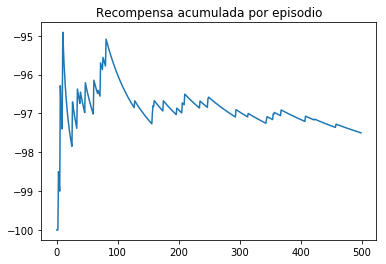

In [10]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

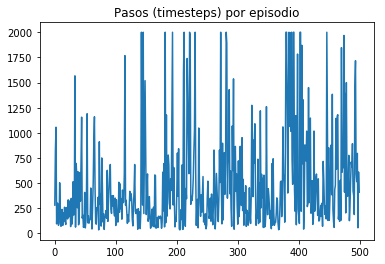

In [11]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

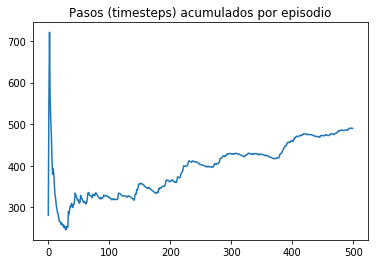

In [12]:
plot_steps_per_episode_smooth(timesteps_ep)

In [13]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [14]:
env.close()

### Q-Learning

In [15]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(2) #Q-Learning

In [16]:
print('Q-Learning: avg_steps_per_episode', avg_steps_per_episode)

Q-Learning: avg_steps_per_episode -89.184


In [17]:
print('Q-Learning: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

Q-Learning: Reward de estado de exito


91

In [18]:
print('Q-Learning: Cdad de Pasos diferentes') 
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

Q-Learning: Cdad de Pasos diferentes


,Cdad
timesteps_ep,
2001.0,12
1684.0,1
755.0,1
744.0,1
580.0,1
442.0,1
395.0,1
372.0,1
368.0,1


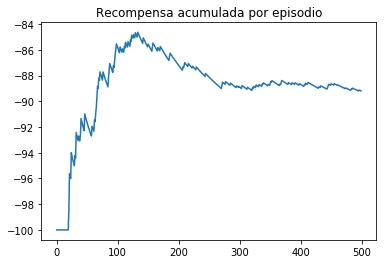

In [19]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

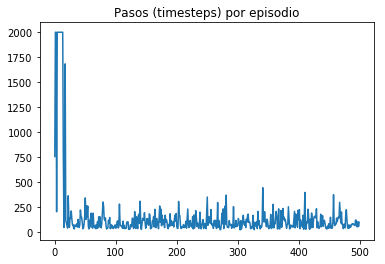

In [20]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

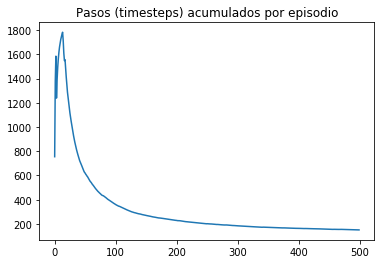

In [21]:
plot_steps_per_episode_smooth(timesteps_ep)

In [22]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [23]:
env.close()

### Comentarios

Para unos mismos parámetros preestablecidos podemos observar lo siguiente:

SARSA: 33 reward diferentes de -100
QLearning: 91 reward diferentes de -100

SARSA: 18 veces llegó a la máx cantidad de pasos (2000)
QLearning: 12 veces llegó a la máx cantidad de pasos (2000)

* SARSA no solamente presenta mayor cantidad del peor reward, sino que el máximo reward (mejor valor) es menor que con QLearning, por ende el avg_steps_per_episode es mejor para este último método.
* SARSA ha llegado más veces a la mayor cdad de pasos, que es 2000, que QLearning.

En ambos casos siempre que se  ha llegado a 2000 pasos el reward es -100 por ende los reward diferentes de -100 son llegadas al destino exitosas. Ver RewardMaxPasos.
Es decir que para los mismos parámetros nos quedamos con QLearning por los resultados obtenidos, ha llegado más veces al estado final.
QLearning tiende a converger un poco más lento, pero tiene la capacidad de continuar aprendiendo mientras se cambian las políticas. Qlearning usa el máximo Q' sobre todas las acciones posibles para el siguiente paso, esto hace que parezca seguir una política greedy con epsilon = 0, es decir, NO explorar en esta parte.
Convergerá entonces en una solución óptima bajo el supuesto de que, después de generar experiencia y capacitación, pasamos a la política greedy.
QLearning aprenderá la política óptima para caminar a lo largo del acantilado, mientras que SARSA aprenderá a elegir una forma más segura al usar la política de épsilon-greedy.

### Análisis de parámetros con SARSA

#### 1er corrida

In [24]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [25]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [26]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -95.778


In [27]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


64

In [28]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,37
1969.0,1
1940.0,1
1934.0,1
1921.0,1
1905.0,1
1891.0,1
1880.0,1
1845.0,1


In [29]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [30]:
env.close()

#### 2da corrida

In [31]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.95 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [32]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [33]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -100.0


In [34]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


0

In [35]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,311
1997.0,1
1976.0,1
1932.0,1
1927.0,1
1919.0,1
1884.0,2
1874.0,1
1863.0,1


In [36]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [37]:
env.close()

#### 3er corrida

In [38]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.05 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [39]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [40]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -76.184


In [41]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


172

In [42]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,239
1863.0,1
1857.0,1
1742.0,1
1709.0,1
1650.0,1
1612.0,1
1596.0,1
1579.0,1


In [43]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [44]:
env.close()

* Epsilon: 

Corrida 1: 64 reward diferentes de -100
Corrida 2: 0 reward diferentes de -100
Corrida 3: 172 reward diferentes de -100

Corrida 1: 37 veces llegó a la máx cantidad de pasos (2000)
Corrida 2: 311 veces llegó a la máx cantidad de pasos (2000)
Corrida 3: 239 veces llegó a la máx cantidad de pasos (2000)

Los mejores resultados se obtuvieron con el menor valor (0,05), es decir que explorando se consigue mejores rewards y se llega a destino. Sin embargo también ha llegado muchas veces a la max cdad de pasos, lo cual significa que las veces que no llegó a los 2000 los rewards han sido muy buenos como para compensar todos esos -100 obtenidos en el máximo de pasos.

#### 4ta corrida

In [45]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [46]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [47]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -95.778


In [48]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


64

In [49]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,37
1969.0,1
1940.0,1
1934.0,1
1921.0,1
1905.0,1
1891.0,1
1880.0,1
1845.0,1


In [50]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [51]:
env.close()

#### 5ta corrida

In [52]:
alpha = 0.95 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [53]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [54]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -96.942


In [55]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


38

In [56]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,19
1999.0,1
1989.0,1
1979.0,1
1923.0,1
1908.0,1
1859.0,1
1852.0,1
1843.0,1


In [57]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [58]:
env.close()

#### 6ta corrida

In [59]:
alpha = 0.05 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [60]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [61]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -93.676


In [62]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


103

In [63]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,17
1629.0,1
1512.0,1
1407.0,1
1348.0,1
1309.0,1
1233.0,1
1159.0,1
1147.0,1


In [64]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [65]:
env.close()

* Alpha: 

Corrida 4: 64 reward diferentes de -100
Corrida 5: 38 reward diferentes de -100
Corrida 6: 103 reward diferentes de -100

Corrida 4: 37 veces llegó a la máx cantidad de pasos (2000)
Corrida 5: 19 veces llegó a la máx cantidad de pasos (2000)
Corrida 6: 17 veces llegó a la máx cantidad de pasos (2000)

Los mejores resultados se obtuvieron con el menor valor (0,05), es decir que se le da poca importancia al nuevo conocimiento. Se llegó a destino en 103 oportunidades y solo 17 veces ocupó el máximo de pasos.

#### 7ma corrida

In [66]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.5 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [67]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [68]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -95.778


In [69]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


64

In [70]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,37
1969.0,1
1940.0,1
1934.0,1
1921.0,1
1905.0,1
1891.0,1
1880.0,1
1845.0,1


In [71]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [72]:
env.close()

#### 8va corrida

In [73]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.95 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [74]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [75]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -85.9


In [76]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


161

In [77]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,3
1930.0,1
1767.0,1
1578.0,1
1317.0,1
1072.0,1
1044.0,1
934.0,1
897.0,1


In [78]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [79]:
env.close()

#### 9va corrida

In [80]:
alpha = 0.5 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.05 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.5 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [81]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [82]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -96.268


In [83]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


52

In [84]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
2001.0,47
1969.0,1
1921.0,1
1919.0,1
1837.0,1
1831.0,1
1830.0,1
1788.0,1
1755.0,2


In [85]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [86]:
env.close()

* Gamma: 

Corrida 7: 64 reward diferentes de -100
Corrida 8: 161 reward diferentes de -100
Corrida 9: 52 reward diferentes de -100

Corrida 7: 37 veces llegó a la máx cantidad de pasos (2000)
Corrida 8: 3 veces llegó a la máx cantidad de pasos (2000)
Corrida 9: 47 veces llegó a la máx cantidad de pasos (2000)

Los mejores resultados se obtuvieron con el de mayor valor (0,95), es decir que se le da mucha importancia al reward futuro. Se llegó a destino en 103 oportunidades y solo 3 veces ocupó el máximo de pasos.

#### Corrida mejores parámetros: SARSA y Q-Learning

In [87]:
alpha = 0.05 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.95 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.05 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [88]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(1) #SARSA

In [89]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -45.968


In [90]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


415

In [91]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
866.0,1
477.0,1
373.0,1
351.0,1
267.0,1
245.0,1
241.0,1
232.0,1
230.0,1


In [92]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [93]:
env.close()

In [94]:
alpha = 0.05 #𝛼 Peso que se le da al conocimiento nuevo
gamma = 0.95 #𝛾 Peso que se le da a la recompensa estimada futura, importancia de la recompensa a corto plazo vs la recompensa a largo plazo
epsilon = 0.05 #𝜖 Cuanto mayor es, más posibilidades hay de explotar en vez de explorar

episodes_to_run = 500

env = gym.make("CliffWalking-v0")

q = np.zeros ((env.observation_space.n, env.action_space.n))

actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [95]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(2) #Q-Learning

In [96]:
print('SARSA: avg_steps_per_episode', avg_steps_per_episode)

SARSA: avg_steps_per_episode -45.306


In [97]:
print('SARSA: Reward de estado de exito') 
unique, counts = np.unique(reward_ep, return_counts=True)
dataset = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset = dataset.rename(columns = {0:'Cdad'})
dataset.index.names = ['reward_ep']
dataset[dataset.index > -100]['Cdad'].sum()

SARSA: Reward de estado de exito


404

In [98]:
unique, counts = np.unique(timesteps_ep, return_counts=True)
dataset2 = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index')
dataset2 = dataset2.rename(columns = {0:'Cdad'})
dataset2.index.names = ['timesteps_ep']
dataset2.sort_values(by=['timesteps_ep'],ascending=False)

,Cdad
timesteps_ep,
807.0,1
530.0,1
373.0,1
360.0,1
328.0,1
299.0,1
287.0,1
283.0,1
247.0,1


In [99]:
RewardMaxPasos = []

for x, y in zip(timesteps_ep, reward_ep):
    if (x == 2001) & (y > -100):
        RewardMaxPasos.append(x)
RewardMaxPasos

[]

In [100]:
env.close()

* SARSA: 

Combinando los mejores parámetros se obtiene resultados muy buenos, en el 83% de las corridas llega al objetivo y en pocos pasos, ya que hay un máximo solo de 866 pasos.

* QLearning: 

Corrida final: 404 reward diferentes de -100

Corrida final: 0 veces llegó a la máx cantidad de pasos (2000)

Combinando los mejores parámetros se obtiene resultados muy buenos, en el 80,8% de las corridas llega al objetivo y en pocos pasos, ya que hay un máximo solo de 807 pasos.



En este caso los métodos varían muy poco en cuanto a sus resultados, SARSA llega a estado destino más veces, por poco, pero tiene un máximo de pasos algo superior.

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$. (alpha, epsilon, gamma)

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\dot{a} \in A}e^{Q(s,\dot{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

Ejemplo: agente CartPole

In [101]:
import gym
import time
from IPython.display import clear_output

env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

Ejemplo: agente Mountain Car

In [102]:
env = gym.make('MountainCar-v0')
observation = env.reset()
for t in range(500):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
clear_output()